# Import

In [2]:
#Importing the necessary 
import os
import numpy as np 
import math
from tqdm import tqdm 
from timeit import default_timer
import matplotlib as mpl 
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import random

import torch, math, matplotlib.pyplot as plt
from torch import nn
# from pyDOE import lhs
# from utils import *

import sklearn
from sklearn.neighbors import NearestNeighbors

from itertools import chain, combinations
import torch.nn as nn
import math

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from typing import Sequence, Tuple, List, Union, Callable
####################################################
from plot_util import plot_training_test_colloc


In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU (M1/M2/M3)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

device = torch.device("cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cpu


In [ ]:
def set_seed_cpu(seed: int = 42):
    random.seed(seed)           # Python random
    np.random.seed(seed)        # NumPy random
    torch.manual_seed(seed)     # PyTorch CPU

set_seed_cpu(42)

# Generate Harmonic Oscillator


$$\ddot{x}(t) + 2\zeta\omega \dot{x}(t) + \omega^2 x(t) = 0$$

where $\omega$ is the undamped angular frequency and $\zeta$ the damping ratio (underdamped regime: $\zeta < 1$ gives oscillatory decay).   
  

The analytic solution (for underdamped $\zeta<1$) is $x(t) = A e^{-\zeta \omega t}\cos(\omega_d t + \phi)$ with $\omega_d=\omega\sqrt{1-\zeta_true_true^2}$.   
For our data, we take $\omega=2\pi$ (1 Hz natural frequency), $\zeta=0.1$ (light damping), and initial displacement $x(0)=1$, velocity $\dot x(0)=0$.


In [5]:
# ------------------------------------------------------------------
# 0. Define the underlying PDE --------------------------------
# ------------------------------------------------------------------
# True parameters for data generation
omega_true = 2*np.pi    # undamped frequency
zeta_true  = 0.1       # damping ratio
A   = 0.5          # new amplitude
phi = 1.2          # new phase in radians

omega_d = omega_true*np.sqrt(1-zeta_true**2)

# Analytical solution function
def x_true(t):
    # Underdamped solution: A*exp(-zeta*omega*t) * cos(omega_d*t + phi)
    return A * np.exp(-zeta_true*omega_true*t) * np.cos(omega_d*t + phi)

# ------------------------------------------------------------------
# 1. generate numpy data (unchanged) --------------------------------
# ------------------------------------------------------------------
N_train = 200
t_train_np = np.sort(np.random.rand(N_train)*5.0)[:,None]
x_train_np = x_true(t_train_np)
x_train_np += 0.5 * np.std(x_train_np) * np.random.randn(*x_train_np.shape)

N_calibration = 50
t_cal_np = np.sort(np.random.rand(N_calibration)*5.0)[:,None]
x_cal_np = x_true(t_cal_np)
x_cal_np += 0.5 * np.std(x_cal_np) * np.random.randn(*x_cal_np.shape)

N_test  = 100
t_test_np  = np.linspace(0,5,N_test)[:,None]
true_solution_np  = x_true(t_test_np)
x_test_np = true_solution_np + (0.5 * np.std(true_solution_np) * np.random.randn(*true_solution_np.shape))

N_colloc = 400
t_colloc_np = np.linspace(0,5,N_colloc)[:,None]

# ------------------------------------------------------------------
# 2. convert to *device* tensors ------------------------------------
# ------------------------------------------------------------------
t_train  = torch.tensor(t_train_np , dtype=torch.float32, device=device,
                        requires_grad=True)
x_train  = torch.tensor(x_train_np , dtype=torch.float32, device=device)

t_cal_np   = torch.tensor(t_cal_np  , dtype=torch.float32, device=device)
x_cal_np   = torch.tensor(x_cal_np  , dtype=torch.float32, device=device)

t_test   = torch.tensor(t_test_np  , dtype=torch.float32, device=device)
x_test   = torch.tensor(x_test_np  , dtype=torch.float32, device=device)

t_colloc = torch.tensor(t_colloc_np, dtype=torch.float32, device=device,
                        requires_grad=True)

true_solution = torch.tensor(true_solution_np  , dtype=torch.float32, device=device)

# ------------------------------------------------------------------
# 3. generate initial conditions -----------------------------------
# ------------------------------------------------------------------
t0 = torch.zeros((1, 1), device=device, dtype=torch.float32)  # no grads needed
x0_val = A * math.cos(phi)                     # scalar Python float
v0_val = -A * zeta_true * omega_true * math.cos(phi)  \
         - A * omega_d      * math.sin(phi)
x0 = torch.tensor([[x0_val ]], device=device, dtype=torch.float32)
v0 = torch.tensor([[v0_val]], device=device, dtype=torch.float32)


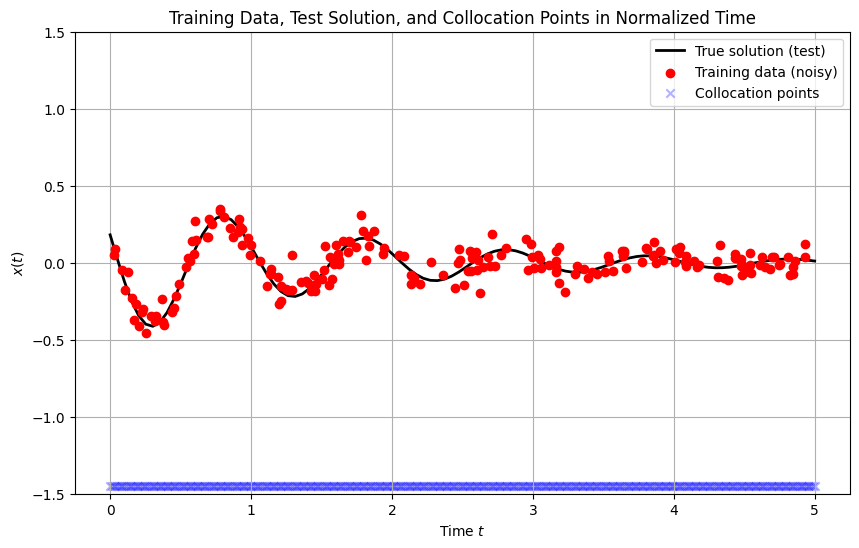

In [6]:
plot_training_test_colloc(t_train, x_train, t_test, true_solution, t_colloc)

# Drop-Out PINN v.s. CP

## Class Definition

In [7]:
class MLP(nn.Module):
    def __init__(self, zeta: float, omega: float, 
                 layers=(1, 64, 64, 64, 1), activation=torch.tanh, learn_pde_var=False):
        super().__init__()
        self.in_features = layers[0]
        self.out_features = layers[-1]
        self.num_layers = len(layers)
        self.act_func = activation

        self.input_layer = nn.Linear(layers[0], layers[1])
        self.hidden_layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(1, self.num_layers - 2)
        ])
        self.output_layer = nn.Linear(layers[-2], layers[-1])

        if learn_pde_var:
            # Learnable physical parameters
            self.zeta = nn.Parameter(torch.tensor(zeta))   # initial guess
            self.omega = nn.Parameter(torch.tensor(omega))  # initial guess
        else:
            self.zeta = torch.tensor(zeta)  # initial guess
            self.omega = torch.tensor(omega)  # initial guess


    def forward(self, x, return_hidden=False):
        x = self.act_func(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.act_func(layer(x))
        hidden = x
        out = self.output_layer(hidden)
        return (out, hidden) if return_hidden else out

In [ ]:
class PINN_MLP_1D(MLP):
    """Learn a PINN model for different 1d PDE"""

    def __init__(self, zeta: float, omega: float, layers, activation=torch.tanh, learn_pde_var=False):
        super().__init__(zeta, omega, layers, activation, learn_pde_var)
    
    def fit_pinn_oscillator(self, 
        t_c, t_d, x_d,
        t0, x0, v0,
        λ_pde = 10.0, λ_ic = 5.0, λ_data = 5.0,
        epochs = 20_000,
        lr = 3e-3,
        print_every = 500,
        scheduler_cls = StepLR,
        scheduler_kwargs = {'step_size': 5000, 'gamma': 0.5},
        warm_up_steps = 5000):

        self.to(device)  # move model to device

        # Ensure tensors are float32 and on correct device
        t_c = t_c.to(dtype=torch.float32, device=device).requires_grad_()
        t_d = t_d.to(dtype=torch.float32, device=device)
        x_d = x_d.to(dtype=torch.float32, device=device)
        t0  = t0.to(dtype=torch.float32, device=device).requires_grad_()
        x0  = x0.to(dtype=torch.float32, device=device)
        v0  = v0.to(dtype=torch.float32, device=device)

        # Optimizer
        opt = torch.optim.Adam(self.parameters(), lr=lr)
        # Scheduler
        scheduler = scheduler_cls(opt, **scheduler_kwargs) if scheduler_cls else None

        # Training History
        tot_loss_his = []
        pde_loss_his = []
        ic_loss_his = []
        data_loss_his = []

        for ep in range(1, epochs + 1):
            zeta = self.zeta
            omega = self.omega

            opt.zero_grad()

            # Warm-up Option: Loss Function with Warm-up Phase
            if ep <= warm_up_steps:
                # Data loss
                x_pred = self(t_d)
                loss_data = ((x_pred - x_d) ** 2).mean()
                loss = loss_data

            else:
                # Data loss
                x_pred = self(t_d)
                loss_data = ((x_pred - x_d) ** 2).mean()

                # PDE residual
                x_colloc = self(t_c)
                dx_dt = torch.autograd.grad(x_colloc, t_c, torch.ones_like(x_colloc), create_graph=True)[0]
                d2x_dt2 = torch.autograd.grad(dx_dt, t_c, torch.ones_like(dx_dt), create_graph=True)[0]
                residual = d2x_dt2 + 2 * zeta * omega * dx_dt + (omega**2) * x_colloc
                loss_pde = (residual ** 2).mean()

                # Initial conditions
                x0_pred = self(t0)
                dx0_pred = torch.autograd.grad(x0_pred, t0, torch.ones_like(x0_pred), create_graph=True)[0]
                loss_ic = (x0_pred - x0) ** 2 + (dx0_pred - v0) ** 2

                # Total loss
                loss = λ_pde * loss_pde + λ_data * loss_data + λ_ic * loss_ic

            loss.backward()
            opt.step()

            if ep <= 40000:  # Stop decreasing the learning rate
                if scheduler:
                    if isinstance(scheduler, ReduceLROnPlateau):
                        scheduler.step(loss.item())
                    else:
                        scheduler.step()

            if (ep % print_every == 0 or ep == 1) and ep>warm_up_steps:  # Only start reporting after the warm-up Phase
                print(f"ep {ep:5d} | L={loss.item():.2e}  "
                    f"data={loss_data.item():.2e}  pde={loss_pde.item():.2e}  "
                    f"ic={loss_ic.item():.2e} | lr={opt.param_groups[0]['lr']:.2e} |"
                    f"zeta={zeta.item():.3e}, omega={omega.item():.3e}")
                
                tot_loss_his.append(loss.item())
                pde_loss_his.append(loss_pde.item())
                ic_loss_his.append(loss_ic.item())
                data_loss_his.append(loss_data.item())

            elif (ep % print_every == 0 or ep == 1): 
                print(f"ep {ep:5d} | L={loss.item():.2e}  "
                    f"data={loss_data.item():.2e}")
                
            return data_loss_his, ic_loss_his, pde_loss_his

In [9]:
class CP_PINN_1D(PINN_MLP_1D):
    """Carry out CP for different 1D PDE"""
    def __init__(self, zeta: float, omega: float, layers, activation=torch.tanh, learn_pde_var=False):
        super().__init__(zeta, omega, layers, activation, learn_pde_var)
    
    ######################## Feature Space Distance ############################
    # Compute the uncertainty as distance in the original feature space 
    def _feature_distance(self, X_cal, X_train, k):
        # Use sklearn to compute kNN distances in the feature space
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X_train)
        distances, _ = nbrs.kneighbors(X_cal)

        avg_dists = np.mean(distances, axis=1)
        return avg_dists # 每一个 calibration point 的 heuristic uncertainty
    
    
    def _conf_metric_feature(self, X_cal, Y_cal, X_train, k=10, eps=1e-8):
        """
        Scaled residual score  s_i = |y_i − ŷ_i| / d_i   (vector-valued)

        Parameters:
            - X_cal, Y_cal, X_train: the training data
            - k: the number nearest neighbour. 
            - eps: the lower bound to prevent if the calibration point
                being too close to its neibouring training data point, leading
                to blowing up conformal score.
        """
        X_cal_tensor = torch.tensor(X_cal, dtype=torch.float32, device=device)

        # ---> remove the stray [0] so we predict *all* N calibration points
        with torch.no_grad():
            Y_pred = self(X_cal_tensor).cpu().numpy()      # shape (N, out_dim)

        raw_residual = np.abs(Y_cal - Y_pred)              # (N, out_dim)

        # k-NN distance in the *feature* (input) space – unchanged
        latent_dist  = self._feature_distance(X_cal, X_train, k=k)  # (N,)

        # ---> prevent divide-by-zero / tiny-distance conformal score blow-ups
        latent_dist  = np.maximum(latent_dist, eps)

        scaled_score = raw_residual / latent_dist[:, None]           # (N, out_dim)
        return scaled_score, latent_dist
    ##############################################################################

    
    ######################### Latent Space Distance ##############################
    def _latent_distance(self, X_cal, X_train, k):
        """
        Compute the average distance from each calibration point to its k nearest neighbors
        from the training set in the latent space.
        """
        self.eval()
        with torch.no_grad():
            H_cal = self(torch.tensor(X_cal, dtype=torch.float32).to(device), return_hidden=True)[1].clone().detach().cpu().numpy()
            H_train = self(torch.tensor(X_train, dtype=torch.float32).to(device), return_hidden=True)[1].clone().detach().cpu().numpy()

        # Use sklearn to compute kNN distances in latent space
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(H_train)
        distances, _ = nbrs.kneighbors(H_cal)

        avg_dists = np.mean(distances, axis=1)
        return avg_dists # 每一个 calibration point 的 heuristic uncertainty
    

    def _conf_metric_latent(self, X_cal, Y_cal, X_train, k=10, eps=1e-8):
        """
        Scaled residual score  s_i = |y_i − ŷ_i| / d_i   (vector-valued)

        Parameters:
            - X_cal, Y_cal, X_train: the training data
            - k: the number nearest neighbour. 
            - eps: the lower bound to prevent if the calibration point
                being too close to its neibouring training data point, leading
                to blowing up conformal score.
        """
        X_cal_tensor = torch.tensor(X_cal, dtype=torch.float32, device=device)

        # ---> remove the stray [0] so we predict *all* N calibration points
        with torch.no_grad():
            Y_pred = self(X_cal_tensor).cpu().numpy()      # shape (N, out_dim)

        raw_residual = np.abs(Y_cal - Y_pred)              # (N, out_dim)

        # k-NN distance in the *feature* (input) space – unchanged
        latent_dist  = self._latent_distance(X_cal, X_train, k=k)  # (N,)

        # ---> prevent divide-by-zero / tiny-distance conformal score blow-ups
        latent_dist  = np.maximum(latent_dist, eps)

        scaled_score = raw_residual / latent_dist[:, None]           # (N, out_dim)
        return scaled_score, latent_dist
    ##############################################################################

    def uq_pred(self, alpha, k, X_test, Y_test, X_cal, Y_cal, X_train, distance_space):
        """
        Implements conformal prediction with latent-space-scaled residuals
        """
        self.k = k
        n = len(X_cal)

        if distance_space == "feature":
            conf_metric_func = self._conf_metric_feature
            distance_func = self._feature_distance
        elif distance_space == "latent":
            conf_metric_func = self._conf_metric_latent
            distance_func = self._latent_distance

        # Step 1: Scaled scores on calibration set
        cal_scores, _ = conf_metric_func(X_cal, Y_cal, X_train, k=self.k)
        qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, axis=0, method="higher")

        # Step 2: Predict and get latent distances for test set
        with torch.no_grad():
            y_pred_test, _ = self(torch.tensor(X_test, dtype=torch.float32).to(device), return_hidden=True)
            y_pred_test = y_pred_test.cpu().numpy()
            test_dists = distance_func(X_test, X_train, k)

        # Step 3: Prediction intervals
        eps = qhat * test_dists[:, None]  # shape: [n_test, output_dim]
        lower = y_pred_test - eps
        upper = y_pred_test + eps

        # Step 4: Coverage
        empirical_coverage = ((Y_test >= lower) & (Y_test <= upper)).mean()
        return [lower, upper], empirical_coverage
                
    #####################################################################
    def naive_heur_uq(self, k, X_test, Y_test, X_train, Y_train, device="cpu", factor: float = 3.0):
        """
        Heuristic UQ via k-NN sample variance.

        Parameters
        ----------
        X_test, Y_test : np.ndarray  – test inputs / true targets
        X_train, Y_train : np.ndarray  – training inputs / targets
        factor : float  – scale-up factor for the error band (default = 1.0)

        Returns
        -------
        bounds : [lower, upper]  – arrays with the same shape as Y_test
        coverage : float         – mean test-set coverage of the interval
        """

        # ----- 1. model mean prediction on the test set -----
        self.eval()
        with torch.no_grad():
            y_pred = self(
                torch.as_tensor(X_test, dtype=torch.float32, device=device)
            ).cpu().numpy()               # shape (n_test, out_dim)

        # ----- 2. k-nearest neighbours in input space -----
        k = k
        nbrs = NearestNeighbors(n_neighbors=k, algorithm="auto").fit(X_train)
        _, idx = nbrs.kneighbors(X_test)  # idx: (n_test, k)

        # ----- 3. local sample variance of neighbour targets -----
        neigh_targets = Y_train[idx]                      # (n_test, k, out_dim)
        # unbiased variance; fall back to 0 when k == 1
        var_local = np.var(neigh_targets, axis=1, ddof=1 if k > 1 else 0)
        sigma_local = np.sqrt(var_local) * factor         # (n_test, out_dim)

        # ----- 4. prediction bands -----
        lower = y_pred - sigma_local
        upper = y_pred + sigma_local

        # ----- 5. empirical coverage on the held-out set -----
        coverage = np.mean((Y_test >= lower) & (Y_test <= upper))

        return [lower, upper], coverage

In [10]:
class DropoutPINN_MLP_1D(PINN_MLP_1D):
    def __init__(self, zeta: float, omega: float, 
                 layers=(1, 64, 64, 64, 1), 
                 activation=torch.tanh,
                 learn_pde_var=False,
                 p_drop=0.1):
        super().__init__(zeta, omega, layers, activation, learn_pde_var)
        
        self.dropout_rate = p_drop

        # Convert function to module
        if activation == torch.tanh:
            act_module = nn.Tanh()
        elif activation == torch.relu:
            act_module = nn.ReLU()
        elif activation == torch.sigmoid:
            act_module = nn.Sigmoid()
        else:
            raise ValueError("Unsupported activation. Use torch.tanh, torch.relu, or torch.sigmoid.")

        # Redefine layers with dropout
        self.input_layer = nn.Sequential(
            nn.Linear(layers[0], layers[1]),
            act_module,
            nn.Dropout(p_drop)
        )

        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(layers) - 2):
            self.hidden_layers.append(nn.Sequential(
                nn.Linear(layers[i], layers[i + 1]),
                act_module,
                nn.Dropout(p_drop)
            ))

        self.output_layer = nn.Linear(layers[-2], layers[-1])
    
    # Redefine the forward() method
    def forward(self, x, return_hidden=False):
        x = self.input_layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        hidden = x
        out = self.output_layer(hidden)
        return (out, hidden) if return_hidden else out

    # -------------- utility ----------
    def _set_dropout(self, active: bool):
        """
        If active=True  ➜ model.train()  (dropout ON)
        If active=False ➜ model.eval()   (dropout OFF)
        """
        if active:
            super().train()   # keep everything else identical
        else:
            super().eval()

    # ------------- TRAINING ----------
    def fit_pinn_oscillator(self, *args, drop_activate=False ,**kwargs):
        # 1 deactivate the dropout during model training
        self._set_dropout(active=drop_activate)

        # 2 call the parent implementation (unchanged)
        return super().fit_pinn_oscillator(*args, **kwargs)

    # ------------- INFERENCE ----------
    @torch.no_grad()
    def predict(self, t, mc_samples=100, return_std=False, drop_activate=False):
        if drop_activate:
            # 1 reactivate dropout *only* for MC-sampling  
            self._set_dropout(active=drop_activate)
            
            # Conduct MCMC sampling using the model with drop out activate
            preds = []
            for _ in range(mc_samples):
                y = super(DropoutPINN_MLP_1D, self).forward(t.float())
                if isinstance(y, tuple):
                    y = y[0]
                preds.append(y.cpu().numpy())

            # 2 switch back to eval to avoid surprises later
            self._set_dropout(active=False)

            preds = np.stack(preds, axis=0)
            mean = preds.mean(axis=0)
            std  = preds.std(axis=0)
        else:                                 # deterministic
            self._set_dropout(False)
            y = super().forward(t)
            y = y[0] if isinstance(y, tuple) else y
            mean = y
            std  = torch.zeros_like(mean)
        return (mean, std) if return_std else mean

## CP Result

### Training

In [12]:
zeta_guess = 0.1
omega_guess = 6.0

cpmd = CP_PINN_1D(zeta=zeta_guess, omega=omega_guess, layers=(1,32,64,128,128,64,32,1), learn_pde_var=False)
cpmd.fit_pinn_oscillator(t_colloc, t_train, x_train, t0, x0, v0,
            λ_pde = 1.0, λ_ic = 10.0, λ_data = 5.0,
            epochs=20000, lr=3e-3, warm_up_steps=5000)


ep     1 | L=2.18e-02  data=2.18e-02
ep   500 | L=4.61e-03  data=4.61e-03
ep  1000 | L=4.59e-03  data=4.59e-03
ep  1500 | L=3.78e-03  data=3.78e-03
ep  2000 | L=3.60e-03  data=3.60e-03
ep  2500 | L=3.23e-03  data=3.23e-03
ep  3000 | L=3.29e-03  data=3.29e-03
ep  3500 | L=3.17e-03  data=3.17e-03
ep  4000 | L=3.63e-03  data=3.63e-03
ep  4500 | L=2.93e-03  data=2.93e-03
ep  5000 | L=2.77e-03  data=2.77e-03
ep  5500 | L=1.89e+00  data=1.16e-02  pde=1.72e+00  ic=1.17e-02 | lr=1.50e-03 |zeta=1.000e-01, omega=6.000e+00
ep  6000 | L=6.95e-01  data=7.64e-03  pde=6.29e-01  ic=2.87e-03 | lr=1.50e-03 |zeta=1.000e-01, omega=6.000e+00
ep  6500 | L=3.33e-01  data=6.25e-03  pde=2.89e-01  ic=1.26e-03 | lr=1.50e-03 |zeta=1.000e-01, omega=6.000e+00
ep  7000 | L=2.14e-01  data=6.05e-03  pde=1.78e-01  ic=5.92e-04 | lr=1.50e-03 |zeta=1.000e-01, omega=6.000e+00
ep  7500 | L=1.51e-01  data=6.04e-03  pde=1.18e-01  ic=2.81e-04 | lr=1.50e-03 |zeta=1.000e-01, omega=6.000e+00
ep  8000 | L=1.16e-01  data=6.14e-03  

### Inference

In [27]:
cp_intervals, cp_coverage = cpmd.uq_pred(alpha=0.5, k=20,
                                      X_test=t_test_np,
                                      Y_test=x_test_np,
                                      X_cal=t_cal_np,
                                      Y_cal=x_cal_np,
                                      X_train=t_train_np,
                                      distance_space="feature"
                                      )

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [28]:
naive_intervals, naive_coverage = cpmd.naive_heur_uq(20,X_test=t_test_np,Y_test=x_test_np,
                                                        X_train=t_train_np, Y_train=x_train_np,
                                                        factor = 1.0)

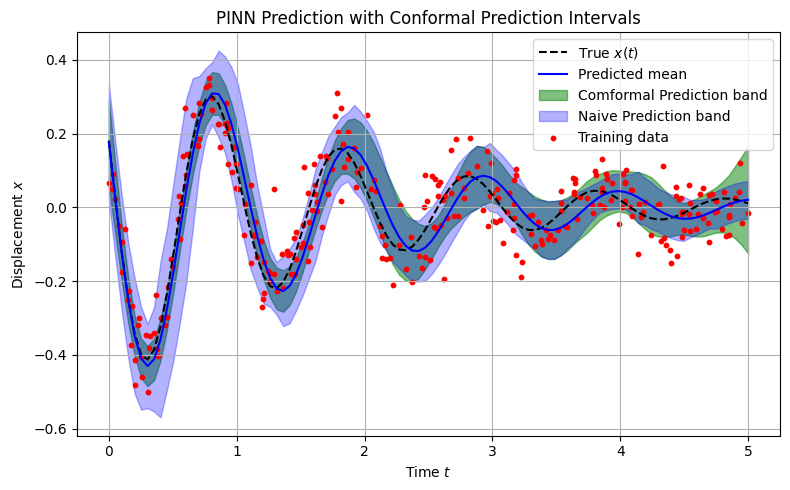

In [31]:
# Naive Prediction
n_lower, n_upper = naive_intervals
n_lower = n_lower.flatten()
n_upper = n_upper.flatten()
# Compute prediction mean
n_pred_mean = (n_lower + n_upper) / 2

# Comformal Prediction
cp_lower, cp_upper = cp_intervals
cp_lower = cp_lower.flatten()
cp_upper = cp_upper.flatten()
# Compute prediction mean
cp_pred_mean = (cp_lower + cp_upper) / 2


# Plot everything
plt.figure(figsize=(8, 5))
plt.plot(t_test_np, true_solution_np, 'k--', label='True $x(t)$')  # Ground truth function
plt.plot(t_test_np, n_pred_mean, 'b', label='Predicted mean')
plt.fill_between(t_test_np.flatten(), cp_lower, cp_upper, color='green', alpha=0.5, label='Comformal Prediction band')
plt.fill_between(t_test_np.flatten(), n_lower, n_upper, color='blue', alpha=0.3, label='Naive Prediction band')

plt.scatter(t_train_np, x_train_np, color='red', s=10, label='Training data')  # Noisy train
plt.scatter(t_test_np, x_test_np, color='red', s=10)  # True test points

plt.xlabel('Time $t$')
plt.ylabel('Displacement $x$')
plt.title('PINN Prediction with Conformal Prediction Intervals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Drop-Out Result

In [49]:
model = DropoutPINN_MLP_1D(zeta=zeta_guess, omega=omega_guess, layers=(1,32,64,128,128,64,32,1), p_drop=0.05)
model.fit_pinn_oscillator(t_colloc, t_train, x_train, t0, x0, v0, drop_activate=False,
            λ_pde =1.0, λ_ic = 10.0, λ_data = 5.0,
            epochs=40000, lr=3e-3, warm_up_steps=10000)

ep     1 | L=4.25e-02  data=4.25e-02
ep   500 | L=1.03e-02  data=1.03e-02
ep  1000 | L=4.14e-03  data=4.14e-03
ep  1500 | L=4.07e-03  data=4.07e-03
ep  2000 | L=4.09e-03  data=4.09e-03
ep  2500 | L=4.01e-03  data=4.01e-03
ep  3000 | L=3.75e-03  data=3.75e-03
ep  3500 | L=3.48e-03  data=3.48e-03
ep  4000 | L=3.00e-03  data=3.00e-03
ep  4500 | L=2.75e-03  data=2.75e-03
ep  5000 | L=2.59e-03  data=2.59e-03
ep  5500 | L=2.28e-03  data=2.28e-03
ep  6000 | L=1.66e-03  data=1.66e-03
ep  6500 | L=2.25e-03  data=2.25e-03
ep  7000 | L=1.71e-03  data=1.71e-03
ep  7500 | L=1.72e-03  data=1.72e-03
ep  8000 | L=1.50e-03  data=1.50e-03
ep  8500 | L=1.44e-03  data=1.44e-03
ep  9000 | L=2.03e-03  data=2.03e-03
ep  9500 | L=1.20e-03  data=1.20e-03
ep 10000 | L=1.48e-03  data=1.48e-03
ep 10500 | L=9.33e+01  data=2.65e-02  pde=1.42e+00  ic=9.18e+00 | lr=7.50e-04 |zeta=1.000e-01, omega=6.000e+00
ep 11000 | L=9.22e+01  data=2.63e-02  pde=4.23e-01  ic=9.17e+00 | lr=7.50e-04 |zeta=1.000e-01, omega=6.000e+00
e

In [50]:
mean, std = model.predict(t_test, mc_samples=100, return_std=True, drop_activate=True)

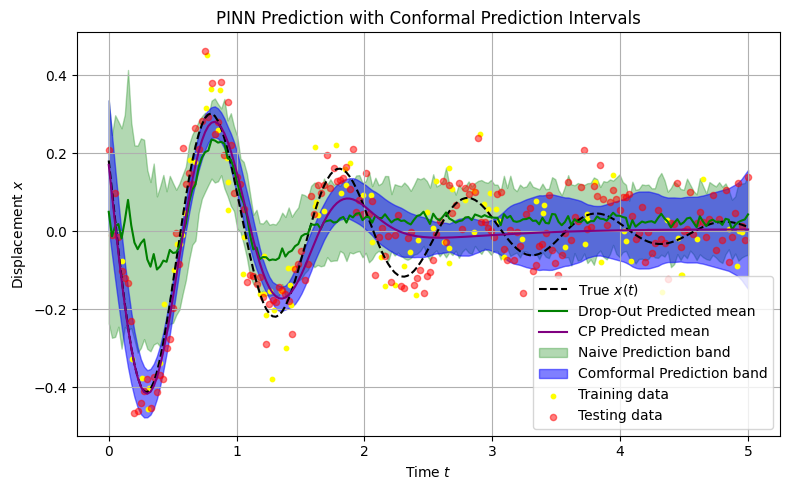

In [51]:
# Naive Prediction
n_lower, n_upper = mean-std , mean+std
n_lower = n_lower.flatten()
n_upper = n_upper.flatten()
# Compute prediction mean
n_pred_mean = mean

# Comformal Prediction
cp_lower, cp_upper = cp_intervals
cp_lower = cp_lower.flatten()
cp_upper = cp_upper.flatten()
# Compute prediction mean
cp_pred_mean = (cp_lower + cp_upper) / 2


# Plot everything
plt.figure(figsize=(8, 5))
plt.plot(t_test_np, true_solution_np, 'k--', label='True $x(t)$')  # Ground truth function
plt.plot(t_test_np, n_pred_mean, color='green', label='Drop-Out Predicted mean')
plt.plot(t_test_np, cp_pred_mean, color='purple', label='CP Predicted mean')
plt.fill_between(t_test_np.flatten(), n_lower, n_upper, color='green', alpha=0.3, label='Naive Prediction band')
plt.fill_between(t_test_np.flatten(), cp_lower, cp_upper, color='blue', alpha=0.5, label='Comformal Prediction band')


plt.scatter(t_train_np, x_train_np, color='yellow', s=10, label='Training data')  # Noisy train
plt.scatter(t_test_np, x_test_np, color='red', s=20, label='Testing data', alpha=0.5)  # True test points

plt.xlabel('Time $t$')
plt.ylabel('Displacement $x$')
plt.title('PINN Prediction with Conformal Prediction Intervals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
